In [176]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [177]:
!wget https://www.dropbox.com/s/t1webrwixdlaacv/space_ga.txt

"wget" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


## Линейная регрессия с батч-оптимизацией(2 балла)

Рассмотрим случай, когда данных в выборке много. В таких случаях используется стохастическая или батч-оптимизация.

Загрузите данные из файла space_ga.csv и нормализуйте их. Мы будем предсказывать первый столбец по шести остальным. Эти данные получены с выборов в США в 1980 году.

In [178]:
import pandas as pd

df = pd.read_csv('space_ga.txt', sep=',', header = None)
df.head()

,0,1,2,3,4,5,6
0,-0.661559,9.972920,9.246286,9.004054,12.134915,-86641472.0,32542207.0
1,-0.650859,10.903347,10.221214,9.965758,13.056638,-87754736.0,30654881.0
2,-0.617114,9.722205,8.753529,8.707648,11.630628,-85388993.0,31863073.0
3,-0.639070,9.273691,8.183118,8.277412,11.243712,-87126855.0,32996943.0
4,-0.700274,10.151519,9.207737,9.240676,12.155100,-86566214.0,33979740.0


In [179]:
df.shape

(3107, 7)

In [180]:
X = df.iloc[:,1:]
y = df[0].values

from sklearn.preprocessing import StandardScaler

In [181]:
X_sc = StandardScaler().fit_transform(X)

In [220]:
X_sc = np.hstack([np.ones(X_sc.shape[0])[...,None], X_sc])

Как вы могли заметить, датасет больше предыдущего. На нём мы попробуем батч-оптимизацию.

Измените функцию для минимизации написанную на семинаре так, чтобы на вход они принимала дополнительный параметр — размер батча. Запустите функцию при разных размерах батча. Прокомментируйте результаты.

In [183]:
def L(X, w, y):
    return np.mean((X @ w - y)**2) / 2

In [184]:
def dL(X, w, y):
    return np.mean((X @ w - y)[..., None] * X, axis = 0)

In [236]:
def optimize_and_plot_steps(learning_rate, x_new = np.full(X_sc.shape[1],2), batch = 16, compute_learning_rate = None):
    x_old = np.zeros(X_sc.shape[1])
    
    eps = 0.0001
    x_list, y_list = [x_new], [L(X_sc, x_new, y)] 
    
    
    i = 0
    while np.mean(abs(x_new - x_old)) > eps:
        if compute_learning_rate is not None:
            learning_rate = compute_learning_rate(i, learning_rate)
            
        ind = np.random.choice(X_sc.shape[0], size = batch, replace= False)
        
        x_old = x_new
        
        x_new = x_old - learning_rate * dL(X_sc[ind], x_old, y[ind])
        
        x_list.append(x_new)
        y_list.append(L(X_sc, x_new, y))
        i += 1
        
    print("Найденный локальный минимум:")
    print(str(x_new).lstrip('[').rstrip(']'))
    print("Number of steps:", i)
    
    plt.figure(figsize=(15,9))
    
    plt.plot(range(len(x_list)), y_list, c="g")
    plt.ylim([0,0.5])
    plt.grid()
    
    plt.title("Loss function")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    
    plt.show()

Найденный локальный минимум:
-0.19177996 -0.19177996 -0.19177996 -0.01714357 -0.03387731 -0.02708658
  0.00302822 -0.00355185  0.12670124
Number of steps: 531


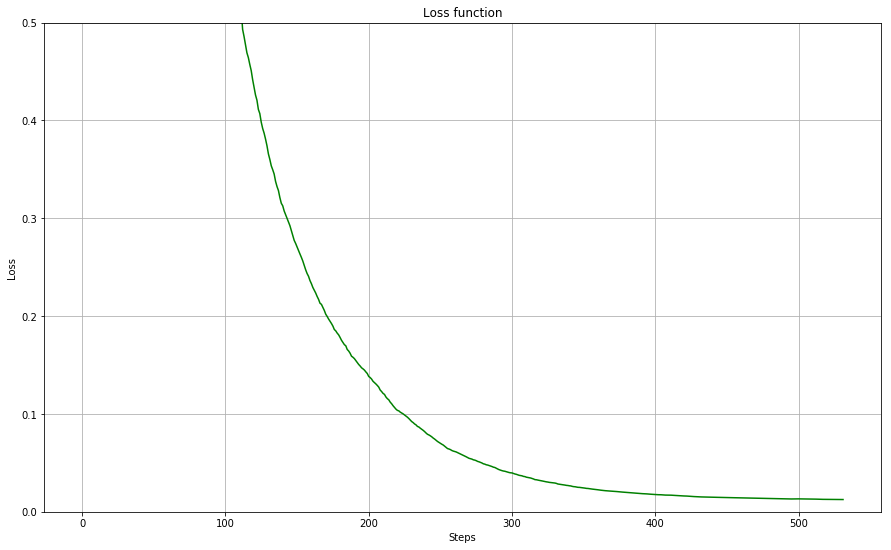

In [237]:
optimize_and_plot_steps(0.01, batch = 16)

Найденный локальный минимум:
-1.93283886e-01 -1.93283886e-01 -1.93283886e-01 -2.23548329e-02
 -4.04060730e-02  1.45335953e-04 -3.26216476e-03  1.25587597e-02
  1.42038155e-01
Number of steps: 464


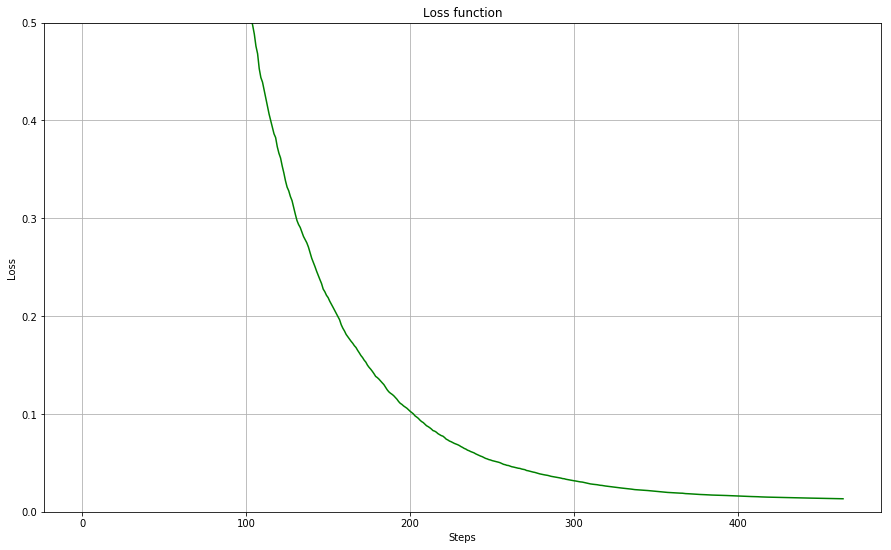

In [238]:
optimize_and_plot_steps(0.01, batch = 32)

Найденный локальный минимум:
-0.19202982 -0.19202982 -0.19202982 -0.02179379 -0.03450651  0.001611
 -0.00535772 -0.00523981  0.12135366
Number of steps: 357


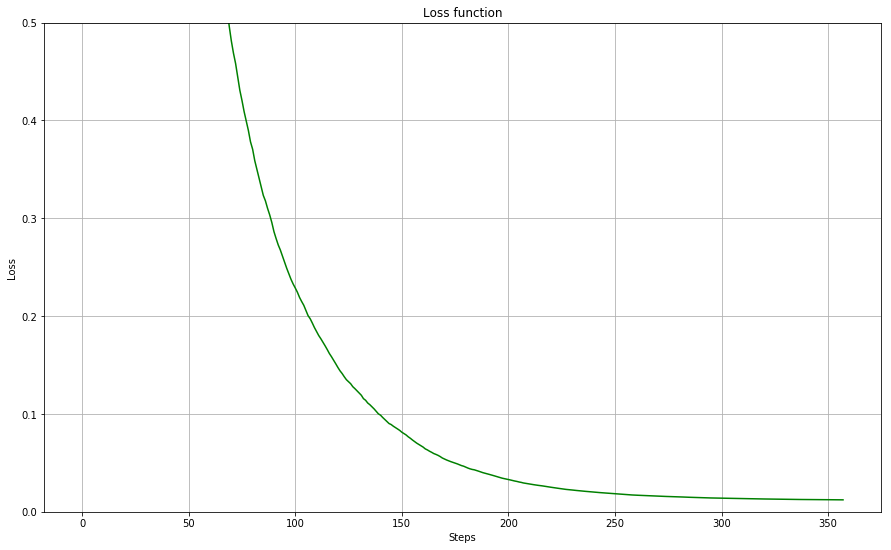

In [239]:
optimize_and_plot_steps(0.015, batch=64)

Из графиков, иллюстрирующих функцию потерь, можно сделать вывод, что чем больше значение параметра "batch", тем более плавно и равномерно функцию стремится к нулю.

## Двумерная классификация(1 балл)

Решим задачу 2D классификации синтетических данных.



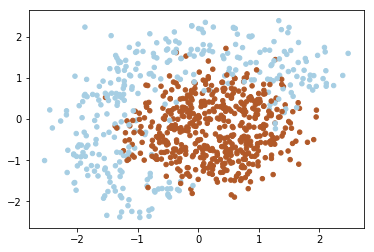

In [240]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()


Как можно заметить, данные сверху линейно неразделимы. Поэтому мы должны добавить дополнительные признаки(или использовать нелинейную модель). Можно заметить, что гиперплоскость разделяющая два класса принимает форму круга, поэтому мы можем добавить квадратичные признаки чтобы сделать классы линейно разделимыми.


![](kernel.png)

In [241]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    
    X_expanded[:,0] = X[ :, 0 ] #feature0
    X_expanded[:,1] = X[ :, 1 ] #feature1
    X_expanded[:,2] = X[ :, 0 ] **2 #feature0^2
    X_expanded[:,3] = X[ :, 1 ] **2 #feature1^2
    X_expanded[:,4] = X[ :, 0 ] * X[ :, 1 ] #feature0*feature1
    X_expanded [:,5]= np.ones(X.shape[0]) 

    return X_expanded

In [242]:
X_expanded = expand(X)

In [243]:
# simple test on random numbers

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

# call your expand function
dummy_expanded = expand(dummy_X)

# what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape == dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")



Seems legit!


## Логистическая регрессия(3 балла)

Для классификации объектов мы будем получать вероятность того что объект принадлежит к классу '1'. Чтобы предсказывать вероятность мы будем использовать вывод линейной модели и логистической функции:


$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; | \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$



In [244]:
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """

    return 1.0 / (1.0 + (np.exp(-np.dot(X,w))))

In [245]:
dummy_weights = np.linspace(-1, 1, 6)
ans_part1 = probability(X_expanded[:1, :], dummy_weights)[0]

Для логистической регрессии оптимальное значение весов $w$ находится с помощью минимизации кросс-энтропии:


Loss для одного сэмпла: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$

Loss для нескольких сэмплов: $$ L(X, \vec{y}, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$




In [246]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function L using formula above.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    y_prob = probability(X,w)
    cross_entropy = y * np.log(y_prob)  + (1.0 - y) * np.log(1.0 - y_prob)
    loss = -np.sum(cross_entropy) / float(X.shape[0])
    
    return np.mean(loss)


Т.к мы обучаем нашу модель с помощью градиентного спуска мы должны считать градиенты.
Для этого нам нужны производные функции потерь по каждому из весов.


$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

Выведите формулу для подсчета градиента.


In [247]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    l = X.shape[0]
    dZ = probability(X, w) - y
    dW = np.dot(dZ, X) / float(l)
    return dW

Вспомогательная функция для визуализации предсказаний:

In [248]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

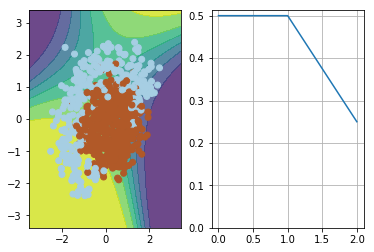

In [249]:
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение
В данной секции мы будем использовать функции, написанные вами, чтобы обучить наш классификатор с помощью стохастического градиентного спуска.


## Mini-batch SGD(1 балл)

Стохастический градиентный спуск берет рандомный батч из $m$ сэмплов на каждой итерации, подсчитывает градиент функции потерь на этом батче и делает шаг градиентного спуска:

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$




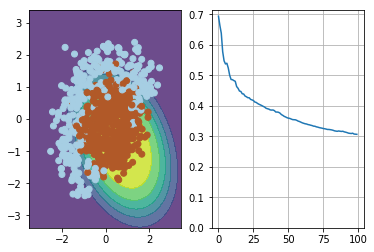

In [250]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    w = w - eta * compute_grad(X_expanded[ind, :], y[ind], w)
        
visualize(X, y, w, loss)
plt.clf()

## SGD with momentum(1 балл)

Momentum это метод позволяющий корректировать шаг SGD в нужное направление и уменьшать осцилляции как показано на рисунке. Данный эффект достигается с помощью добавления предыдущих шагов с коэффициентом $\alpha$ к текущему градиенту для каждого шага с обновлением весов.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](sgd.png)



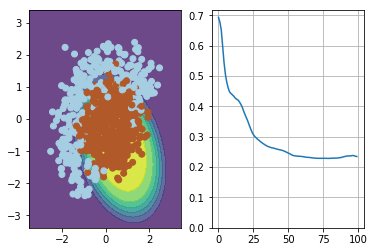

In [251]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    nu = alpha * nu + eta * compute_grad(X_expanded[ind, :], y[ind], w)
    w = w - nu

visualize(X, y, w, loss)
plt.clf()

## ADAM(2 балла)
Реализуйте метод ADAM, использующий градиенты и квадраты градиентов сглаженные экспоненциальным скользящим средним:


\begin{eqnarray}
m_t &=& \beta_1 m_{t-1} + (1-\beta_1) g_t\\
s_t &=& \beta_2 s_{t-1} + (1-\beta_2) g_t^2 \\
w_t &=& w_{t-1} - \eta \times \frac{\sqrt{ 1 -  \beta_2^t}}{ 1 - \beta_1^t} \times \frac{ m_t }{ \sqrt{s_t+eps}}
\end{eqnarray}

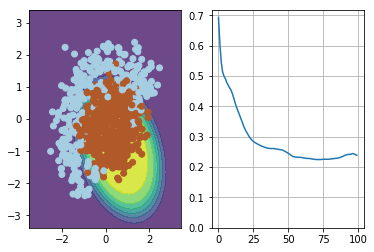

In [252]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
beta_1 = 0.9 # moving average of gradient
beta_2 = 0.999 # moving average of gradient norm squared
g2 = None # we start with None so that you can update this value correctly on the first iteration
eps = 1e-8

m = np.zeros_like(w)
s = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)
    
    dw = compute_grad(X_expanded[ind,:],y[ind],w)
    
    
    m = (beta_1 * m + (1 - beta_1) * dw)
    s = (beta_2 * s + (1 - beta_2) * dw**2)
    w = w - eta * (np.sqrt(1-beta_2**(i+1))/(1-beta_1**(i+1))) * (m  / (np.sqrt(s + eps))) 

visualize(X, y, w, loss)
plt.clf()